# SEIRD fixed infectious rate

## Import modules

In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
plt.style.use('seaborn-whitegrid')
plt.rcParams.update({
    'pgf.texsystem': 'pdflatex',
    'text.usetex': True,
    'font.family': 'serif',
    'font.size': 12,
    'axes.labelsize': 12,
    'axes.grid': True,
    'grid.linewidth': 0.7,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'figure.figsize': (4.774*2, 2.950*2)
})
b, o, g, r = plt.rcParams['axes.prop_cycle'].by_key()['color'][:4]

## All inputs

In [2]:
# all data
DATA_DIR = 'data'
FILE_NAME = 'initial_timeseries_SEIRD.csv' 
FILE_PATH = os.path.join(os.pardir, DATA_DIR, FILE_NAME)
df = pd.read_csv(FILE_PATH)

# derived data
cum_positives = np.cumsum(df.confirmed_positives.values)
cum_deceased = np.cumsum(df.confirmed_deceased.values)

# training_data
I_train = cum_positives - df.estimate_recovered.values
R_train = df.estimate_recovered.values
D_train = cum_deceased

# initial conditions
S0 = I_train[-1] + R_train[-1] + D_train[-1]
E0 = 10
I0 = 1
R0 = 0
D0 = 0
ic = [S0, E0, I0, R0, D0]

# transmission rate
beta = 0.5

# dates
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(I_train.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))

# accuracy
pcr_sens = 0.9
pcr_spec = 0.99

## Model

In [3]:
# loss fun
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

# model
class SEIRD_model(object):
    def __init__(self):
        pass
    
    def fit(
        self, 
        active_cases, 
        recovered_cases,
        death_cases,
        initial_conditions,
        initial_guess=[0.1, 0.1, 0.1, 0.1],
        ):
        self.active_cases = active_cases
        self.recovered_cases = recovered_cases
        self.death_cases = death_cases
        self.removed_cases = self.recovered_cases + self.death_cases
        loss = []
        def print_loss(p):
            loss.append(
                SEIRD_model._loss(
                    p, 
                    self.active_cases, 
                    self.recovered_cases,
                    self.death_cases,
                    initial_conditions,
                    )
            )
            
        self.y0 = initial_conditions
        opt = minimize(
            fun=SEIRD_model._loss, 
            x0=initial_guess,
            args=(self.active_cases, self.recovered_cases, self.death_cases,
                  self.y0),
            method='L-BFGS-B',
            bounds=[(1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0), (1e-5, 1.0),],
            options={'maxiter': 1000, 'disp': True},
            callback=print_loss,
        )
        self.delta, self.alpha, self.gamma, self.mu = opt.x
        return (self.delta, self.alpha, self.gamma, self.mu), loss

    def simulate(self):
        sol = solve_ivp(
            fun=SEIRD_ode, 
            t_span=(0, self.active_cases.size), 
            y0=self.y0, 
            args=(self.delta, self.alpha, self.gamma, self.mu),
            method='RK45', 
            t_eval=np.arange(0, self.active_cases.size, 1), 
            vectorized=True,
        )
        return (sol.y[0], sol.y[1], sol.y[2], sol.y[3], sol.y[4])
    
    @staticmethod
    def _loss(params, active_cases, recovered_cases, death_cases, 
              initial_conditions):
        size = active_cases.size
        sol = solve_ivp(
            fun=SEIRD_ode, 
            t_span=(0, size), 
            y0=initial_conditions, 
            args=params,
            method='RK45', 
            t_eval=np.arange(0, size, 1), 
            vectorized=True,
        )
        return mse(sol.y[2], active_cases) \
               + mse(sol.y[3], recovered_cases) \
               + mse(sol.y[4], death_cases)

## Initialization and training

In [4]:
model = SEIRD_model()
params, loss = model.fit(I_train, R_train, D_train, ic)

## Evaluation and visualization

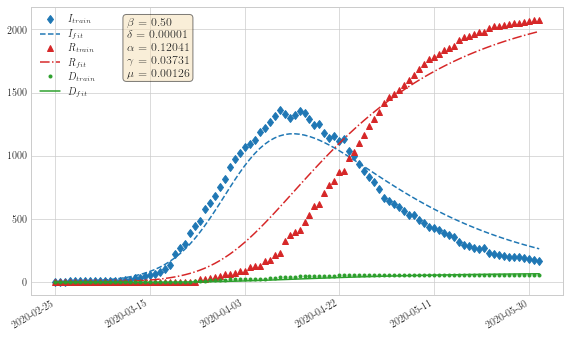

In [5]:
start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(I_train.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))
(S_sim, E_sim, I_sim, R_sim, D_sim) = model.simulate()
fig = plt.figure()
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(dts, I_train, 'd', c=b, label='$I_{train}$')
ax.plot(dts, I_sim, '--', c=b, label='$I_{fit}$')
ax.plot(dts, R_train, '^', c=r, label='$R_{train}$')
ax.plot(dts, R_sim, '-.', c=r, label='$R_{fit}$')
ax.plot(dts, D_train, '.', c=g, label='$D_{train}$')
ax.plot(dts, D_sim, '-', c=g, label='$D_{fit}$')
ax.text(0.18, 0.96,
        '\n'.join((
            r'$\beta$ = %.2f' % (beta, ),
            r'$\delta$ = %.5f' % (params[0], ), 
            r'$\alpha$ = %.5f' % (params[1], ), 
            r'$\gamma$ = %.5f' % (params[2], ),
            r'$\mu$ = %.5f' % (params[3], )
        )),
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()
fname = 'SEIRD_fitted_fixed-beta_first-wave_uc-None'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')

## Basic reproduction number

$ R_0 = \frac{\beta}{\delta + \alpha} $

In [6]:
R0 = beta / (params[1] + params[2])
R0

3.1701403427401784

## Loss over epochs

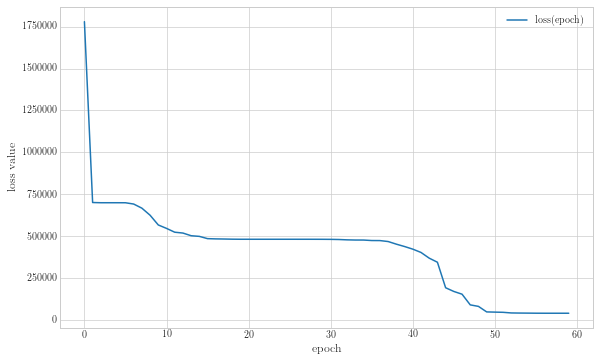

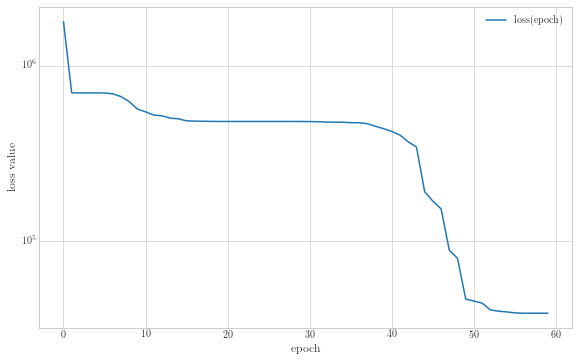

In [12]:
fig = plt.figure()
ax = fig.subplots()
ax.plot(loss, label='loss(epoch)')
ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()
fname = 'SEIRD_fitted_loss'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')

fig = plt.figure()
ax = fig.subplots()
ax.plot(loss, label='loss(epoch)')
ax.set_yscale('log')
ax.set_xlabel('epoch')
ax.set_ylabel('loss value')
ax.legend()
plt.show()
fname = 'SEIRD_fitted_loss-log'
fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')

## Plotting 95% confidence intervals using the sensitivity as a qualitative measure of the confirmed positive result

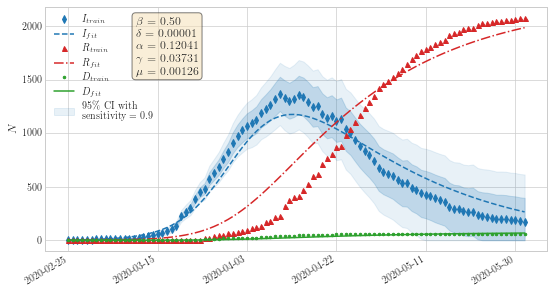

In [8]:
# uncertainty quantification in ci_level% CI
ci_level = 95
if ci_level == 99:
    ci_m = 2.576
elif ci_level == 98:
    ci_m = 2.326
elif ci_level == 95:
    ci_m = 1.96
elif ci_level == 90:
    ci_m = 1.645
else:
    ci_m = 0

if ci_level in [90, 95, 98, 99]:
    lbl = f'{ci_level}\% CI with\nsensitivity = {pcr_sens}'
    fname = f'SEIRD_fitted_fixed-beta_first-wave_uc-{int(pcr_sens*100)}sens-{ci_level}ci'


std_sens_err = np.sqrt(np.divide(
    (1 - pcr_sens) * pcr_sens, 
    df.confirmed_positives.values,
    out=np.zeros(df.confirmed_positives.values.shape, dtype=float), 
    where=df.confirmed_positives.values!=0,
))
sens_lb_ci = pcr_sens - ci_m * std_sens_err
sens_lb = pcr_sens
true_positives_lb_ci = sens_lb_ci * df.confirmed_positives.values
true_positives_lb = sens_lb * df.confirmed_positives.values
active_lb_ci = np.cumsum(true_positives_lb_ci) - df.estimate_recovered.values
active_lb = np.cumsum(true_positives_lb) - df.estimate_recovered.values
active_lb_ci[np.where(active_lb_ci<0)] = 0 
active_lb[np.where(active_lb<0)] = 0

true_positives_ub_ci = 2 * df.confirmed_positives.values - true_positives_lb_ci
true_positives_ub = 2 * df.confirmed_positives.values - true_positives_lb
active_ub_ci = np.cumsum(true_positives_ub_ci) - df.estimate_recovered.values
active_ub = np.cumsum(true_positives_ub) - df.estimate_recovered.values

start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(I_train.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))
fig = plt.figure(figsize=(9, 5))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(dts, I_train, 'd', c=b, markersize=5, label='$I_{train}$')
ax.plot(dts, I_sim, '--', c=b, label='$I_{fit}$')
ax.plot(dts, R_train, '^', c=r, markersize=5, label='$R_{train}$')
ax.plot(dts, R_sim, '-.', c=r, label='$R_{fit}$')
ax.plot(dts, D_train, '.', c=g, markersize=5, label='$D_{train}$')
ax.plot(dts, D_sim, '-', c=g, label='$D_{fit}$')
ax.fill_between(dts, active_lb, active_ub, color=b, alpha=0.2)
ax.fill_between(dts, active_lb_ci, active_ub_ci, color=b, alpha=0.1, label=lbl)
ax.text(0.18, 0.96,
        '\n'.join((
            r'$\beta$ = %.2f' % (beta, ),
            r'$\delta$ = %.5f' % (params[0], ), 
            r'$\alpha$ = %.5f' % (params[1], ), 
            r'$\gamma$ = %.5f' % (params[2], ),
            r'$\mu$ = %.5f' % (params[3], )
        )),
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_ylabel('$N$')
ax.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()

fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')

## Plotting 95% confidence intervals using both the sensitivity and the specificity as qualitative measures of the confirmed positive result

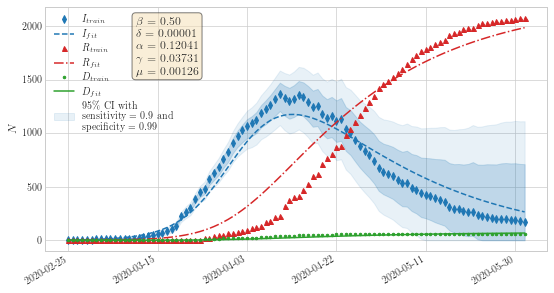

In [9]:
ci_level = 95
if ci_level == 99:
    ci_m = 2.576
elif ci_level == 98:
    ci_m = 2.326
elif ci_level == 95:
    ci_m = 1.96
elif ci_level == 90:
    ci_m = 1.645
else:
    ci_m = 0

if ci_level in [90, 95, 98, 99]:
    lbl = f'{ci_level}\% CI with\nsensitivity = {pcr_sens} and\nspecificity = {pcr_spec}'
    fname = f'SEIRD_fitted_fixed-beta_first-wave_uc-{int(pcr_sens*100)}sens-{int(pcr_spec*100)}spec-{ci_level}ci'

std_sens_err = np.sqrt(np.divide(
    (1 - pcr_sens) * pcr_sens, 
    df.confirmed_positives.values,
    out=np.zeros(df.confirmed_positives.values.shape, dtype=float), 
    where=df.confirmed_positives.values!=0,
))
pcr_sens_ci = pcr_sens - ci_m * std_sens_err
true_positives_lb = pcr_sens * df.confirmed_positives.values
true_positives_lb_ci = pcr_sens_ci * df.confirmed_positives.values
active_lb = np.cumsum(true_positives_lb) - df.estimate_recovered.values
active_lb_ci = np.cumsum(true_positives_lb_ci) - df.estimate_recovered.values
active_lb[np.where(active_lb<0)] = 0
active_lb_ci[np.where(active_lb_ci<0)] = 0

tests = np.concatenate((np.array([df.total_tests.values[0]]), df.total_tests.values[:-1]))
negatives = tests - df.confirmed_positives.values
std_spec_err = np.sqrt(np.divide(
    (1 - pcr_spec) * pcr_spec, 
    negatives,
    out=np.zeros(negatives.shape, dtype=float), 
    where=negatives!=0,
))
pcr_spec_ci = pcr_spec - ci_m * std_spec_err
true_negatives = pcr_spec * negatives
true_negatives_ci = pcr_spec_ci * negatives
false_negatives = negatives - true_negatives
false_negatives_ci = negatives - true_negatives_ci
true_positives_ub = false_negatives + df.confirmed_positives.values
true_positives_ub_ci = false_negatives_ci + df.confirmed_positives.values
active_ub = np.cumsum(true_positives_ub) - df.estimate_recovered.values
active_ub_ci = np.cumsum(true_positives_ub_ci) - df.estimate_recovered.values

start_dt = datetime.datetime(2020, 2, 25)
end_dt = start_dt + datetime.timedelta(I_train.size)
dts = mdates.drange(start_dt, end_dt, datetime.timedelta(days=1))
fig = plt.figure(figsize=(9, 5))
ax = fig.subplots(nrows=1, ncols=1)
ax.plot(dts, I_train, 'd', c=b, markersize=5, label='$I_{train}$')
ax.plot(dts, I_sim, '--', c=b, label='$I_{fit}$')
ax.plot(dts, R_train, '^', c=r, markersize=5, label='$R_{train}$')
ax.plot(dts, R_sim, '-.', c=r, label='$R_{fit}$')
ax.plot(dts, D_train, '.', c=g, markersize=5, label='$D_{train}$')
ax.plot(dts, D_sim, '-', c=g, label='$D_{fit}$')
ax.fill_between(dts, active_lb, active_ub, color=b, alpha=0.2)
ax.fill_between(dts, active_lb_ci, active_ub_ci, color=b, alpha=0.1, label=lbl)
ax.text(0.18, 0.96,
        '\n'.join((
            r'$\beta$ = %.2f' % (beta, ),
            r'$\delta$ = %.5f' % (params[0], ), 
            r'$\alpha$ = %.5f' % (params[1], ), 
            r'$\gamma$ = %.5f' % (params[2], ),
            r'$\mu$ = %.5f' % (params[3], )
        )),
        transform=ax.transAxes,
        verticalalignment='top', 
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
ax.set_ylabel('$N$')
ax.legend()
_ = fig.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
_ = fig.gca().xaxis.set_major_locator(mdates.DayLocator(interval=19))
_ = plt.gcf().autofmt_xdate()
plt.show()

fig.savefig(fname=os.path.join('output', 'figs', fname + '.pdf'), 
            format='pdf', bbox_inches='tight')